<a href="https://colab.research.google.com/github/Ali-7800/ME471/blob/main/projects/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Problem 1.2
Plot the displacement, strain, and stress solutions over the domain of the bar.

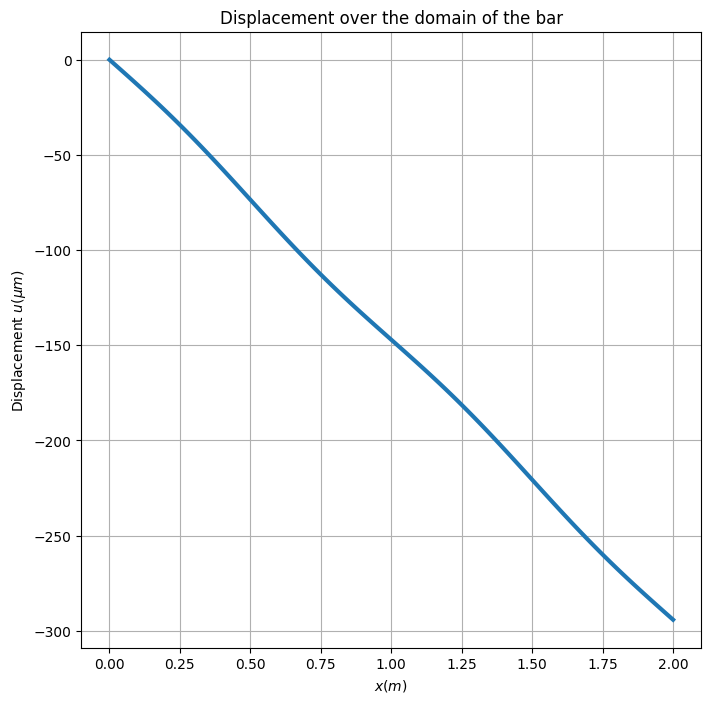

In [75]:
x = np.linspace(0,2,100)
u_analytical = (1e-5-(1e-4/2*np.pi))*x+(1e-4/(4*np.pi**2))*np.sin(2*np.pi*x)
plt.figure(figsize=(8, 8))
ax =plt.plot(x,u_analytical*1e6,linewidth=3)
plt.xlabel("$x(m)$")
plt.ylabel("Displacement $u(\mu m)$")
plt.title("Displacement over the domain of the bar")
plt.grid()

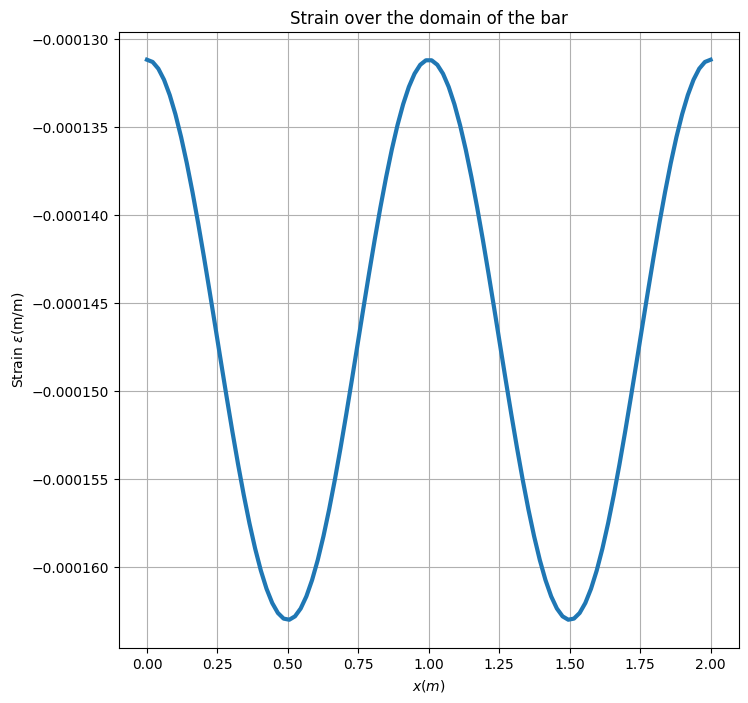

In [55]:
x = np.linspace(0,2,100)
strain = (1e-5-(1e-4/2*np.pi))+(1e-4/(2*np.pi))*np.cos(2*np.pi*x)
plt.figure(figsize=(8, 8))
plt.plot(x,strain,linewidth=3)
plt.xlabel("$x(m)$")
plt.ylabel("Strain $\epsilon$(m/m)")
plt.title("Strain over the domain of the bar")
plt.grid()

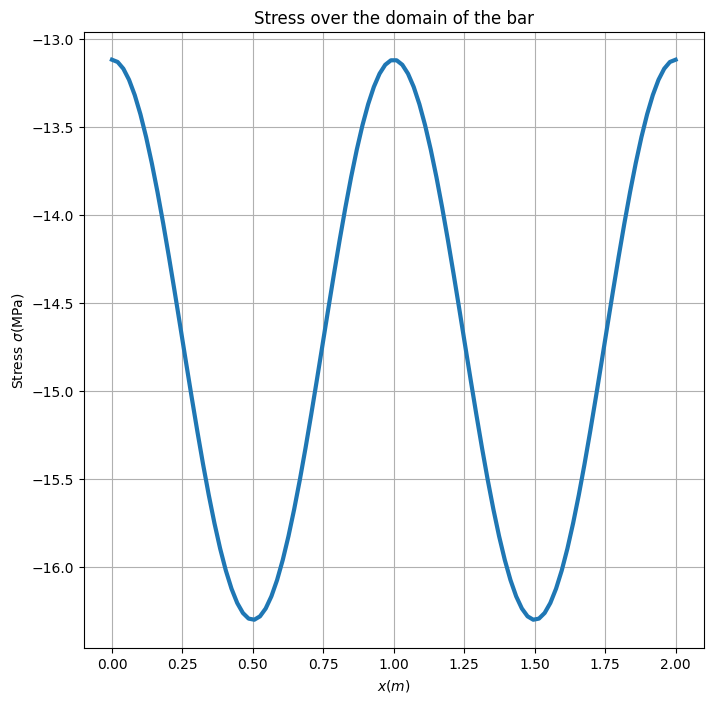

In [56]:
x = np.linspace(0,2,100)
E = 100e9 #100GPa
stress_analytical = E*strain
plt.figure(figsize=(8, 8))
ax =plt.plot(x,stress_analytical*1e-6,linewidth=3)
plt.xlabel("$x(m)$")
plt.ylabel("Stress $\sigma$(MPa)")
plt.title("Stress over the domain of the bar")
plt.grid()

# Problem 2.1
Write a 1D FEA code in Python to solve the problem described in Question 1 using linear 1D
rod elements.

In [71]:
class Fixed1DRodFEA:
  def __init__(
        self,
        length:float,
        end_force:float,
        cross_sectional_area:callable,
        youngs_modulus:callable,
        body_force:callable,
        ):
    self.length = length
    self.cross_sectional_area = cross_sectional_area
    self.youngs_modulus = youngs_modulus
    self.end_force = end_force
    self.body_force = body_force

  def assemble_stiffness_matrix(self,N:int):
    stiffness_matrix = np.zeros((N+1,N+1))
    h_e = self.length/N
    EA_bar = sp.integrate.quad(lambda x: self.youngs_modulus(x)*self.cross_sectional_area(x), 0, self.length)[0]/h_e
    for i in range(N):
      stiffness_matrix[i:i+2,i:i+2] = (EA_bar/h_e)*np.array([[1,-1],[1,-1]])
    return stiffness_matrix[:1,:1],stiffness_matrix[:1,1:],stiffness_matrix[1:,:1],stiffness_matrix[1:,1:]#Kpp,Kpf,Kfp,Kff

  def find_load_vector(self,node_positions:np.ndarray,N:int):
    p = np.zeros_like(node_positions)
    for i in range(N):
      x1 = node_positions[i]
      x2 = node_positions[i+1]
      N1 = lambda x: (x-x2)/(x1-x2)
      N2 = lambda x: (x-x1)/(x2-x1)
      p[i] += sp.integrate.quad(lambda x: N1(x)*self.body_force(x)*self.cross_sectional_area(x), x1, x2)[0]
      p[i+1] += sp.integrate.quad(lambda x: N2(x)*self.body_force(x)*self.cross_sectional_area(x), x1, x2)[0]
    p[-1] += self.end_force
    return p[:-1],p[-1:] #return pf,pp

  def solve(self,N:int):
    node_positions = np.linspace(0,self.length,N+1) #N+1 nodes
    Kpp,Kpf,Kfp,Kff = self.assemble_stiffness_matrix(N)
    pf,pp = self.find_load_vector(node_positions,N)
    U = np.zeros_like(node_positions)
    U[1:] = np.linalg.solve(Kff,pf) #This is Uf, Up = 0 always in the case of a fixed rod
    R = Kpf@U[1:] - pp #Up = 0 always in the case of a fixed rod
    strain = 0
    stress = lambda x: strain*self.youngs_modulus(x)
    return node_positions,U,strain,stress,R

  def plot(self,node_positions,U,strain,stress):
    pass


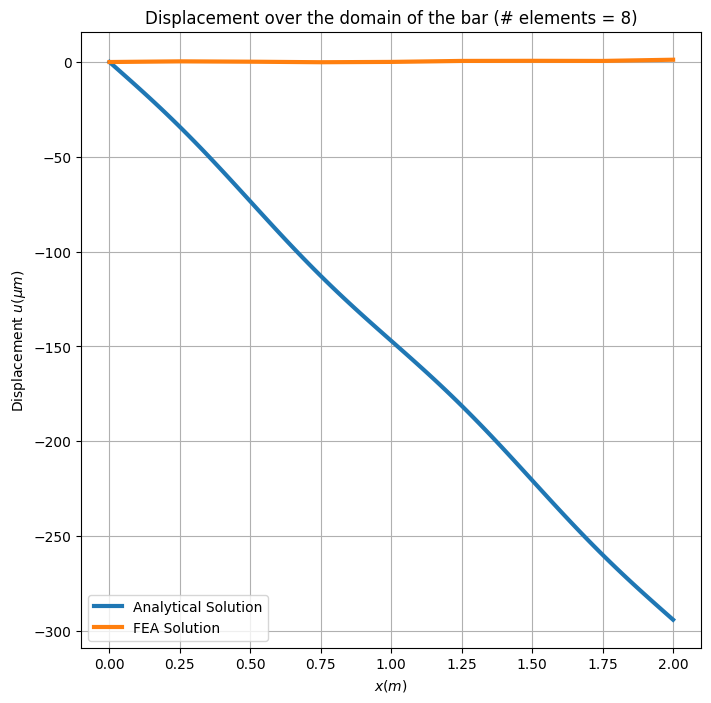

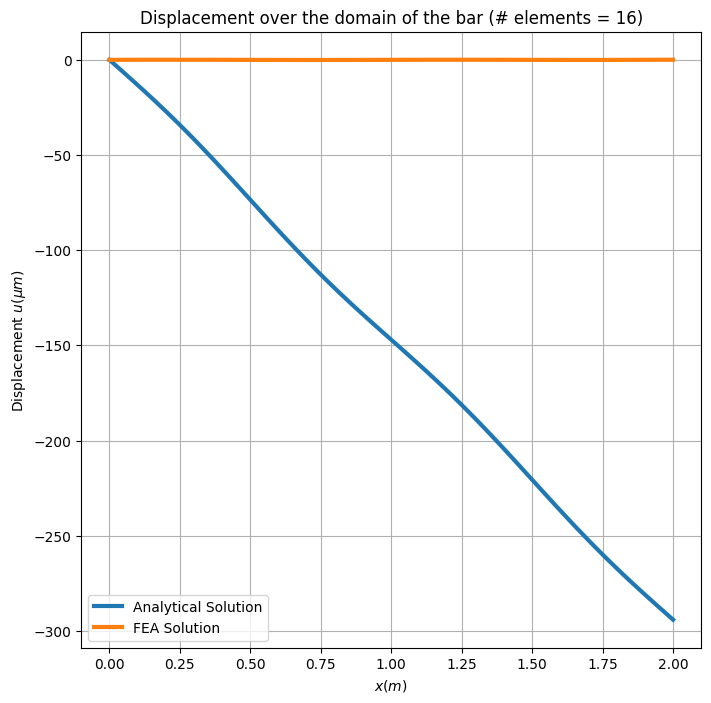

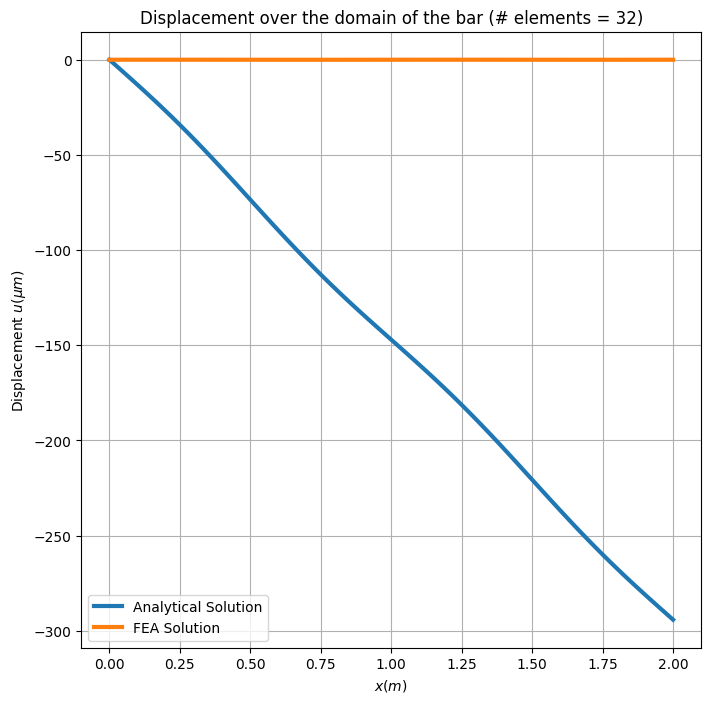

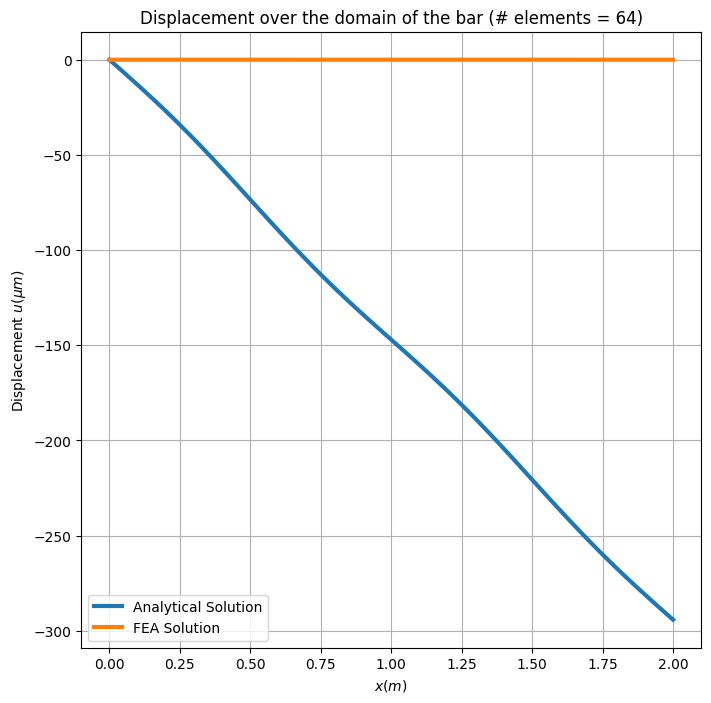

In [79]:
L = 2 #m
E = 100e9 #100GPa
Fr = 1e6 # N
A = lambda x:1 # m^2
b = lambda x:1e7*np.sin(4*np.pi*x/L) #N/m^3
problem_1_rod = Fixed1DRodFEA(
    length=L,
    end_force=Fr,
    cross_sectional_area=A,
    youngs_modulus=lambda x:E,
    body_force=b,
)
meshes = [8,16,32,64]
for N in meshes:
  node_positions,u_FEA,strain,stress,R = problem_1_rod.solve(N)
  plt.figure(figsize=(8, 8))
  plt.plot(x,u_analytical*1e6,linewidth=3,label="Analytical Solution")
  plt.plot(node_positions,u_FEA*1e6,linewidth=3,label="FEA Solution")
  plt.legend()
  plt.xlabel("$x(m)$")
  plt.ylabel("Displacement $u(\mu m)$")
  plt.title("Displacement over the domain of the bar (# elements = {0})".format(N))
  plt.grid()
